# Dataset available at kaggle

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

# Install libraries, packages and dataset

In [ ]:
#!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install timm
#!pip install --upgrade opencv-contrib-python

In [ ]:
#!unzip /content/Facial-Expression-Dataset.zip

In [ ]:
#!unzip -o /content/Facial-Expression-Dataset.zip -d /content/ && find /content/ -name '__MACOSX' -exec rm -rf {} + -o -name '._*' -exec rm {} +


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [ ]:
TRAIN_IMG_FOLDER_PATH = '/Users/nguyenthang/Desktop/machine_learning/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/Users/nguyenthang/Desktop/machine_learning/Facial-Expression-Dataset/validation/'

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 100
DEVICE = 'cpu'
MODEL_NAME = 'densenet121'

# Load Dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [ ]:
# Data augmentation
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor() #PIL / numpy arr -> torch tensor -> (h,w,c) -> (c,h,w)
])
valid_augs = T.Compose([ # converting the image into a Tensor array, which can be changed to different dimensions.
    T.ToTensor()
])

In [ ]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform=train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform=valid_augs)

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 57528
Total no. of examples in validset : 14244


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'confident': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7, 'unconfident': 8}


In [ ]:
num_of_class = len(trainset.class_to_idx)
print(num_of_class)

9


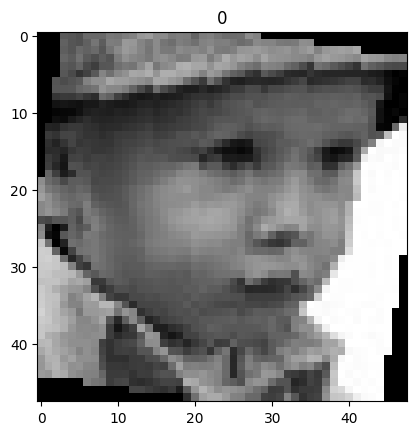

In [ ]:
image, label = trainset[20]
plt.imshow(image.permute(1,2,0))
plt.title(label);

# Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 1798
Total no. of batches in validloader : 446


In [ ]:
for images, labels in trainloader:
  break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [ ]:
!pip3 install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import timm
from torch import nn

In [ ]:
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel, self).__init__()
    self.eff_net = timm.create_model('densenet121', pretrained = True, num_classes = num_of_class)

  def forward(self, images, labels = None):
    logits = self.eff_net(images)

    if labels != None:
      loss = nn.CrossEntropyLoss()(logits, labels)
      return logits, loss
    return logits


In [ ]:
model = FaceModel()
model.to(DEVICE);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

# Create Train and Eval Function

In [ ]:
from tqdm import tqdm

In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train_fn(model, dataloader, optimizer, current_epo):
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + '/' + str(EPOCHS))

  for t,data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': '%6f' %float(total_loss / (t+1)), 'acc': '%6f' %float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)

In [ ]:
def eval_fn(model, dataloader, current_epo):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH" + "[VALID]" + str(current_epo + 1) + '/' + str(EPOCHS))

  for t,data in enumerate(tk):
    images, labels = data
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits, loss = model(images, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': '%6f' %float(total_loss / (t+1)), 'acc': '%6f' %float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc / len(dataloader)

# Create Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print('SAVE-BEST-WEIGHTS')
    best_valid_loss = valid_loss

EPOCH[TRAIN]1/100:  68%|██████▊   | 1224/1798 [1:29:58<42:03,  4.40s/it, loss=1.838800, acc=0.325010]

# Inference

In [ ]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'confident', 'unconfident']

def view_classify(img, ps):

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [ ]:
#torch.cuda.clear_cache()

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms

label = 0

# Load and transform the image
image_path = 'img2.jpg'
image = Image.open(image_path)

# Define the transformation to convert the image to tensor and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = transform(image)
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)

### Webcam Detection